Власний датасет слід підготувати наступним чином. Оберіть один з двох варіантів:

* Для приміщення: 12-15 знімків приміщення з різних точок зору. Важливо, щоб поле зору фотографій перекривалося між собою.

* Для архітектурного об'єкту: 15-20 знімків архітектурного об'єкту з різних точок зору. Не обов'язково фотографувати всі кути об'єкту, але важливо, щоб поле зору фотографій перекривалося між собою.

**Ні в якому разі не знімати інфраструктуру чи військові об'єкти!**

**Зліва є провідник файлів, відкрийте і перейдіть на Hierarchical-Localization/datasets і створіть папку inloc. Завантажте всі фото, крім одного. Воно буде тестом. В inloc створіть папку query і туди завантажте те тестове фото. Якщо переплутаєте, втратите годину.** Структура має бути така:



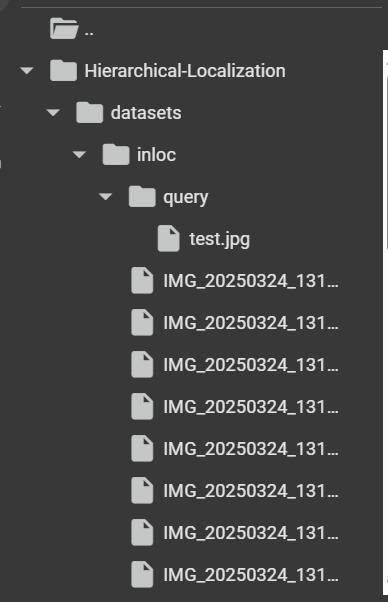

## Підготовка середовища

Клонує репозиторій HLOC.

**Може забрати кілька хвилин.**

In [3]:
!git clone --quiet --recursive https://github.com/cvg/Hierarchical-Localization/
%cd /content/Hierarchical-Localization
!pip install --progress-bar off --quiet -e .
!pip install --progress-bar off --quiet --upgrade plotly

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Імпортує потрібні бібліотеки.

In [4]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from pprint import pformat
from hloc import extract_features, match_features, localize_inloc, visualization


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Директорії файлів, з якими прога буде працювати.

In [5]:
dataset = Path("datasets/inloc/") # В цю директорію будуть завантажені зображення для мапінгу
pairs = Path("pairs/inloc/") # В цю директорію будуть завантажені пари зображень для мапінгу
loc_pairs = pairs / "pairs-sfm.txt" # В цей файл будуть записані пари зображень для локалізаці
outputs = Path("outputs/inloc/") # В цю директорію будуть зберігатися результати роботи
results = outputs / "InLoc_hloc_superpoint+superglue_netvlad40.txt" # В цей файл буде записани

## Побудова 3D-карти сцени

Основні конфігурації для отримання особливостей зображень і співставлення між ними.

In [6]:
print(f"Конфігурації для детекції особливостей:\n{pformat(extract_features.confs)}")
print(f"Конфігурації для співставлення особливостей:\n{pformat(match_features.confs)}")


Конфігурації для детекції особливостей:
{'aliked-n16': {'model': {'model_name': 'aliked-n16', 'name': 'aliked'},
                'output': 'feats-aliked-n16',
                'preprocessing': {'grayscale': False, 'resize_max': 1024}},
 'd2net-ss': {'model': {'multiscale': False, 'name': 'd2net'},
              'output': 'feats-d2net-ss',
              'preprocessing': {'grayscale': False, 'resize_max': 1600}},
 'dir': {'model': {'name': 'dir'},
         'output': 'global-feats-dir',
         'preprocessing': {'resize_max': 1024}},
 'disk': {'model': {'max_keypoints': 5000, 'name': 'disk'},
          'output': 'feats-disk',
          'preprocessing': {'grayscale': False, 'resize_max': 1600}},
 'megaloc': {'model': {'name': 'megaloc'},
             'output': 'global-feats-megaloc',
             'preprocessing': {'resize_max': 1024}},
 'netvlad': {'model': {'name': 'netvlad'},
             'output': 'global-feats-netvlad',
             'preprocessing': {'resize_max': 1024}},
 'openibl': {

Визначення шляхів до директорій та файлів і конфігурацій для виконання побудови 3D-моделі:

In [20]:
%cd /content/Hierarchical-Localization
images = Path('datasets/inloc')
outputs = Path('outputs/inloc/')
!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'
print(list(extract_features.confs.keys()))
print(list(match_features.confs.keys()))
feature_conf = extract_features.confs['superpoint_max']
matcher_conf = match_features.confs['superpoint+lightglue']


/content/Hierarchical-Localization
['superpoint_aachen', 'superpoint_max', 'superpoint_inloc', 'r2d2', 'd2net-ss', 'sift', 'sosnet', 'disk', 'aliked-n16', 'dir', 'netvlad', 'openibl', 'megaloc']
['superpoint+lightglue', 'disk+lightglue', 'aliked+lightglue', 'superglue', 'superglue-fast', 'NN-superpoint', 'NN-ratio', 'NN-mutual', 'adalam']


Визначення списку зображень для мапінгу:

10 зображень для манінгу


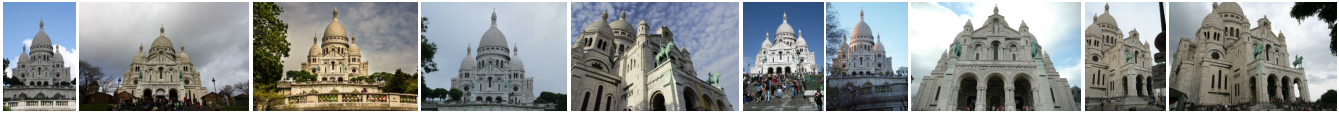

In [21]:
from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d
import cv2

# Define valid image extensions
valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

# Filter out non-image files
references = [
    str(p.relative_to(images)) for p in images.iterdir()
    if p.suffix.lower() in valid_extensions
]

print(len(references), "зображень для манінгу")

# Read only valid images
valid_images = []
for r in references:
    img_path = images / r
    img = read_image(img_path)
    if img is not None:
        valid_images.append(img)

plot_images(valid_images, dpi=25)


Ось що робить кожен рядок:

```extract_features.main(feature_conf, images, image_list=references, feature_path=features)``` – витягує особливості зображень.

```pairs_from_exhaustive.main(sfm_pairs, image_list=references)``` – створює пари зображень для співставлення.

```match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)``` – знаходить відповідності між особливостями різних зображень.

**Ця штука працює десь годину, тому перевірте, чи на попередніх кроках ви все зробили правильно!**

In [22]:
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)


[2025/04/08 20:58:10 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-rmax1600',
 'preprocessing': {'grayscale': True, 'resize_force': True, 'resize_max': 1600}}


Loaded SuperPoint model


100%|██████████| 10/10 [01:55<00:00, 11.50s/it]
[2025/04/08 21:00:05 hloc INFO] Finished exporting features.
[2025/04/08 21:00:05 hloc INFO] Found 45 pairs.
[2025/04/08 21:00:05 hloc INFO] Matching local features with configuration:
{'model': {'features': 'superpoint', 'name': 'lightglue'},
 'output': 'matches-superpoint-lightglue'}
/usr/local/lib/python3.11/dist-packages/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /root/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv.pth
100%|██████████| 45.3M/45.3M [00:00<00:00, 205MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of w

PosixPath('outputs/inloc/matches.h5')

Запуск інкрементальної процедури Structure-from-Motion і побудування моделі:

In [23]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)

[2025/04/08 21:22:55 hloc INFO] Creating an empty database...
[2025/04/08 21:22:55 hloc INFO] Importing images into the database...
[2025/04/08 21:22:55 hloc INFO] Importing features into the database...
100%|██████████| 10/10 [00:00<00:00, 628.29it/s]
[2025/04/08 21:22:55 hloc INFO] Importing matches into the database...
100%|██████████| 45/45 [00:00<00:00, 650.61it/s]
[2025/04/08 21:22:55 hloc INFO] Performing geometric verification of the matches...
[2025/04/08 21:22:58 hloc INFO] Running 3D reconstruction...
[2025/04/08 21:23:07 hloc INFO] Reconstructed 1 model(s).
[2025/04/08 21:23:07 hloc INFO] Largest model is #0 with 10 images.
[2025/04/08 21:23:07 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_cameras = 10
	num_images = 10
	num_reg_images = 10
	num_points3D = 2128
	num_observations = 9521
	mean_track_length = 4.47415
	mean_observations_per_image = 952.1
	mean_reprojection_error = 0.915287
	num_input_images = 10


Візуалізація реконструйованої 3D-моделі.

Червоні квадрати - камери в різних ракурсах.

*   ЛКМ - обертати візуалізацію
*   ПКМ - переміщувати її
*   СКМ - масштабувати її


In [24]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

Візуалізація особливих точок, які були тріангульовані в 3D-модель, на парі зображень:

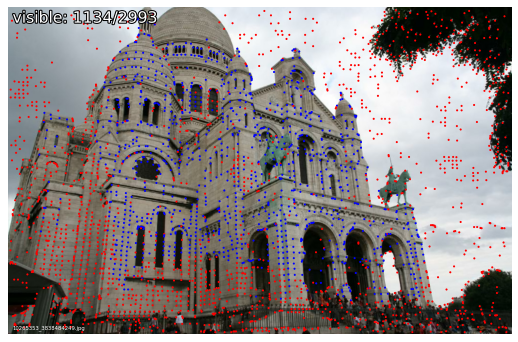

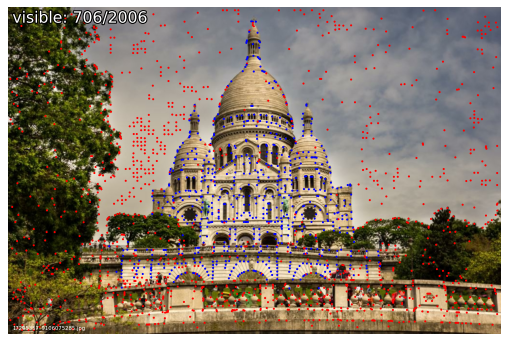

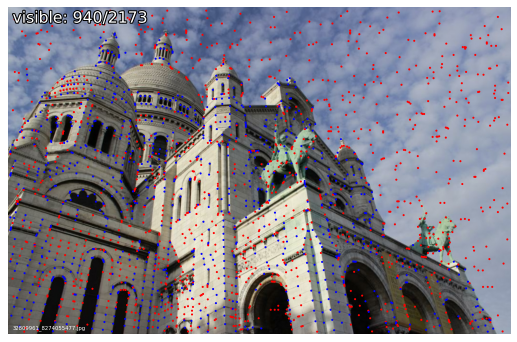

In [25]:
visualization.visualize_sfm_2d(model, images, selected=[3,4,5], color_by='visibility', n=2)

## Локалізація зображення


Показує тестове зображення

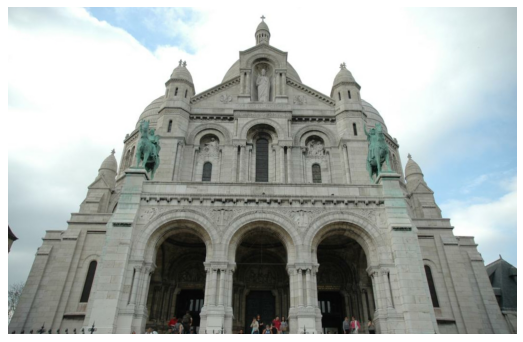

In [26]:
query = 'query/test.jpg'
plot_images([read_image(images / query)], dpi=75)

Вилучення особливостей для тестового зображення та їх співставлення з зображеннями з мапи.

**Бере десь 10 хв**

In [27]:
references_registered = [model.images[i].name for i in model.reg_image_ids()]
extract_features.main(feature_conf, images, image_list=[query], feature_path=features, overwrite=True)
pairs_from_exhaustive.main(loc_pairs, image_list=[query], ref_list=references_registered)
match_features.main(matcher_conf, loc_pairs, features=features, matches=matches, overwrite=True);

[2025/04/08 21:33:02 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-rmax1600',
 'preprocessing': {'grayscale': True, 'resize_force': True, 'resize_max': 1600}}


Loaded SuperPoint model


100%|██████████| 1/1 [00:15<00:00, 15.33s/it]
[2025/04/08 21:33:17 hloc INFO] Finished exporting features.
[2025/04/08 21:33:17 hloc INFO] Found 10 pairs.
[2025/04/08 21:33:17 hloc INFO] Matching local features with configuration:
{'model': {'features': 'superpoint', 'name': 'lightglue'},
 'output': 'matches-superpoint-lightglue'}
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning:

This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

100%|██████████| 10/10 [01:31<00:00,  9.14s/it]
[2025/04/08 21:34:49 hloc INFO] Finished exporting matches.


Визначення позиції камери за допомогою алгоритму RANSAC.

Тут може вискакнути така помилка:

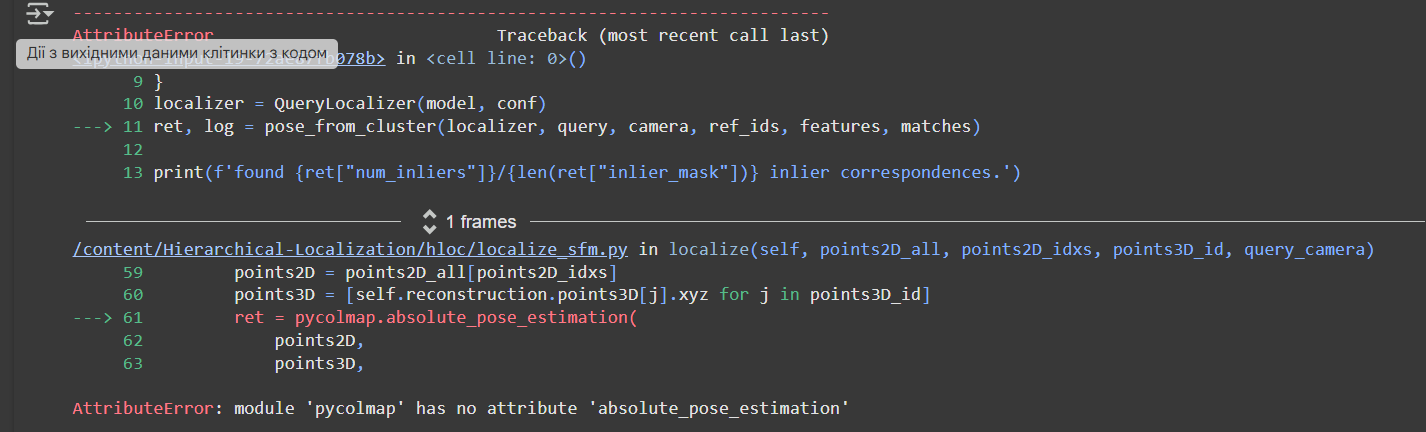

Клікніть по файлу, в якому знаходиться помилка, і файл відкриється для редагування у боковій панелі. Вам треба буде відредагувати два файли: localize_sfm.py і visualization.py.

Виправлення помилки з absolute_pose_estimation: поміняйте назву метода на estimate_and_refine_absolute_pose

Виправлення помилки з inliers: поміняйте назву елементу результату inliers на inlier_mask.

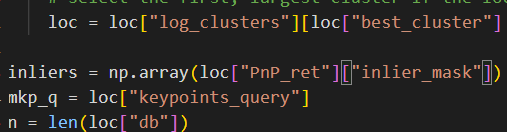

found 579/1224 inlier correspondences.


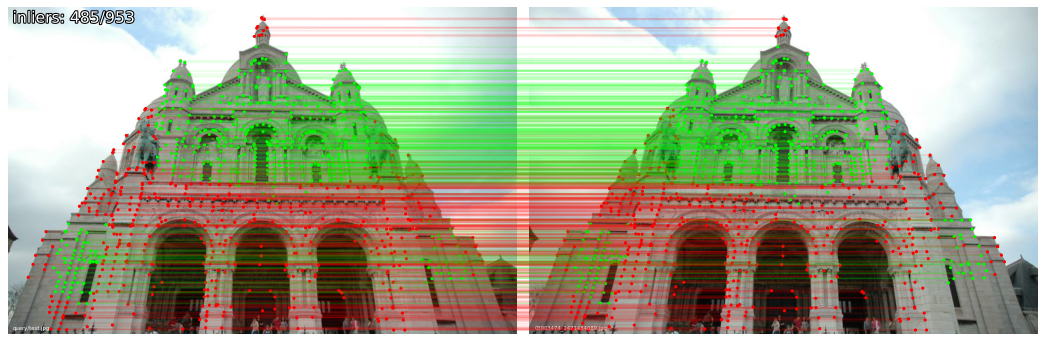

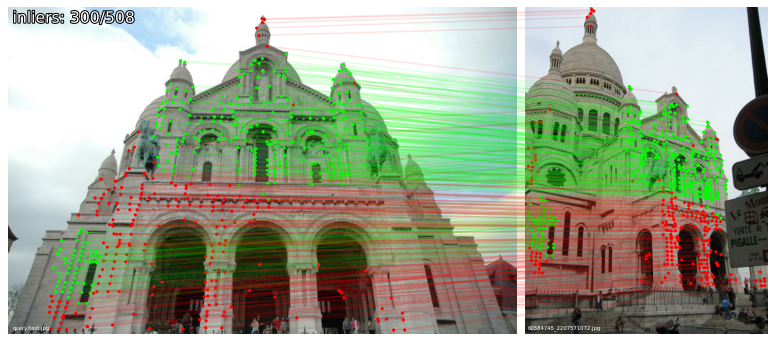

In [30]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(n).image_id for n in references_registered]
conf = {
    'estimation': {'ransac': {'max_error': 12}},
    'refinement': {'refine_focal_length': True, 'refine_extra_params': True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inlier_mask"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

В результаті ви маєте отримати інформацію про кількість особливостей, які були знайдені на тестовому зображенні, і візуалізувати результати локалізації. Занотуйте у вашому звіті результати локалізації.

Оцінка і візуалізація позиції камери з тестового зображення, візуалізація позиції камери в 3D-моделі та 2D-3D відповідностей:

In [31]:
pose = pycolmap.Image(cam_from_world=ret['cam_from_world'])
viz_3d.plot_camera_colmap(fig, pose, camera, color='rgba(0,255,0,0.5)', name=query, fill=True)
# visualize 2D-3D correspodences
import numpy as np
inl_3d = np.array([model.points3D[pid].xyz for pid in np.array(log['points3D_ids'])[ret['inlier_mask']]])
viz_3d.plot_points(fig, inl_3d, color="lime", ps=1, name=query)
fig.show()